# Fine-tune BLIP using Hugging Face `transformers` and `datasets` 🤗

This tutorial is largely based from the [GiT tutorial](https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing) on how to fine-tune GiT on a custom image captioning dataset. Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions.
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset.

## Set-up environment

## Load the image captioning dataset

Let's load the image captioning dataset, you just need few lines of code for that.

In [2]:
from datasets import Dataset
import pandas as pd
from PIL import Image
import os

# Paths
image_folder = "gul-ahmed-data/images"
metadata_csv = "gul-ahmed-data/gul_ahmed_metadata.csv"

# Load the metadata
metadata = pd.read_csv(metadata_csv)

# Define a function to load images
def load_image(example):
    image_path = os.path.join(image_folder, example["Image Filename"])
    example["image"] = Image.open(image_path).convert("RGB")  # Ensure RGB format
    return example

# Convert the metadata into a Hugging Face dataset
dataset = Dataset.from_pandas(metadata)

# Add the images to the dataset
dataset = dataset.map(load_image)

# Example usage: Accessing an image and its metadata
print(dataset[0])  # Access the first sample


Map: 100%|██████████| 1195/1195 [02:20<00:00,  8.48 examples/s]

{'Product ID': 0, 'Product Title': 'Darcy Unstitched Fabric Blended with Gift Box', 'Brand': 'Gul Ahmed', 'Image Filename': 'image0.jpg', 'Image Path': './gul-ahmed-data/images/image0.jpg', 'Image URL': 'https://www.gulahmedshop.com/media/catalog/product/d/a/darcy_unstitched_fabric_blended_with_gift_box-black_3_.jpg?optimize=medium&auto=webp&bg-color=255,255,255&fit=bounds&canvas=2:3&width=450&height=675', 'Product URL': 'https://www.gulahmedshop.com/darcy-unstitched-fabric-blended-with-gift-box', 'Description': 'Craft your wardrobe essentials with the finest fabrics from GulAhmed Men’s Collection, offering unmatched quality and style.', 'Additional Info': "{'Color:': 'Black', 'Product Type:': '2 Piece', 'Gender:': 'Men', 'Discount Percentage:': '31% to 40%', 'Shirt Fabric:': 'Wash & Wear'}", 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=450x675 at 0x1E321DF0CE0>}


In [3]:
from datasets import DatasetDict

# Split your dataset
split_dataset = dataset.train_test_split(test_size=0.2)

# Convert to DatasetDict for ease of use
dataset_dict = DatasetDict({
    "train": split_dataset["train"],
    "test": split_dataset["test"]
})

print(dataset_dict)


DatasetDict({
    train: Dataset({
        features: ['Product ID', 'Product Title', 'Brand', 'Image Filename', 'Image Path', 'Image URL', 'Product URL', 'Description', 'Additional Info', 'image'],
        num_rows: 956
    })
    test: Dataset({
        features: ['Product ID', 'Product Title', 'Brand', 'Image Filename', 'Image Path', 'Image URL', 'Product URL', 'Description', 'Additional Info', 'image'],
        num_rows: 239
    })
})


Let's retrieve the caption of the first example:

In [8]:
dataset_dict["train"][345]["Description"]

'Ready to wear Elevate your outfit with a touch of timeless charm - our light pink polyester scarf adds a subtle yet sophisticated flair, perfect for draping elegantly or knotting as a chic accessory.'

And the corresponding image

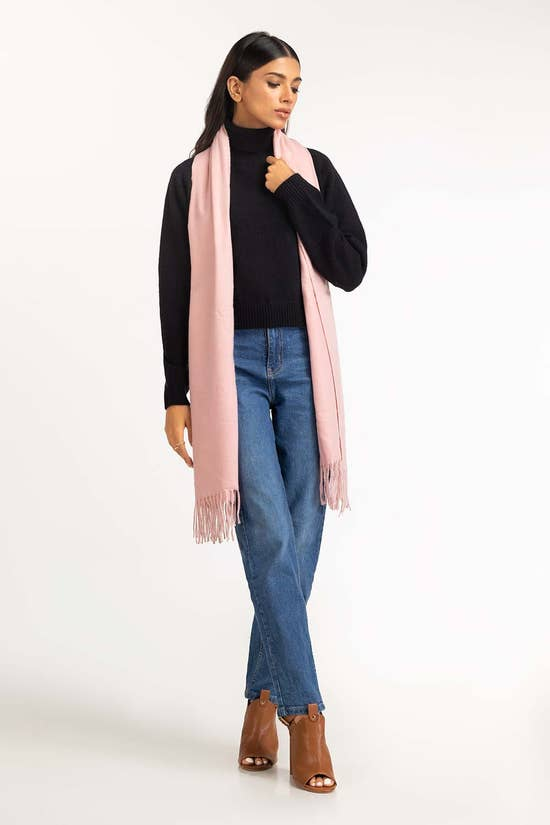

In [10]:
dataset_dict["train"][345]["image"]

## Create PyTorch Dataset

The lines below are entirely copied from the original notebook!

In [15]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["Description"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

## Load model and processor

In [12]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

Now that we have loaded the processor, let's load the dataset and the dataloader:

In [16]:
train_dataset = ImageCaptioningDataset(dataset_dict["train"], processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

## Train the model

Let's train the model! Run the simply the cell below for training the model

In [17]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(10):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0
Loss: 13.021360397338867
Loss: 10.25151538848877
Loss: 10.178622245788574
Loss: 10.130644798278809
Loss: 10.096161842346191
Loss: 9.969727516174316
Loss: 10.072415351867676
Loss: 9.956673622131348
Loss: 10.083541870117188
Loss: 9.845504760742188
Loss: 9.773110389709473
Loss: 10.081748962402344
Loss: 9.380878448486328
Loss: 9.511676788330078
Loss: 8.670300483703613
Loss: 8.552465438842773
Loss: 8.54746150970459
Loss: 8.353095054626465
Loss: 8.089807510375977
Loss: 7.885823726654053
Loss: 7.836684703826904
Loss: 7.62789249420166
Loss: 7.422979831695557
Loss: 7.18562126159668
Loss: 7.0608720779418945
Loss: 6.803640842437744
Loss: 6.77671480178833
Loss: 6.579078674316406
Loss: 6.369223594665527
Loss: 6.414588451385498
Loss: 6.171629905700684
Loss: 6.167928218841553
Loss: 5.875824928283691
Loss: 5.777526378631592
Loss: 5.542730808258057
Loss: 5.52507209777832


KeyError: 'input_ids'

## Inference

Let's check the results on our train dataset

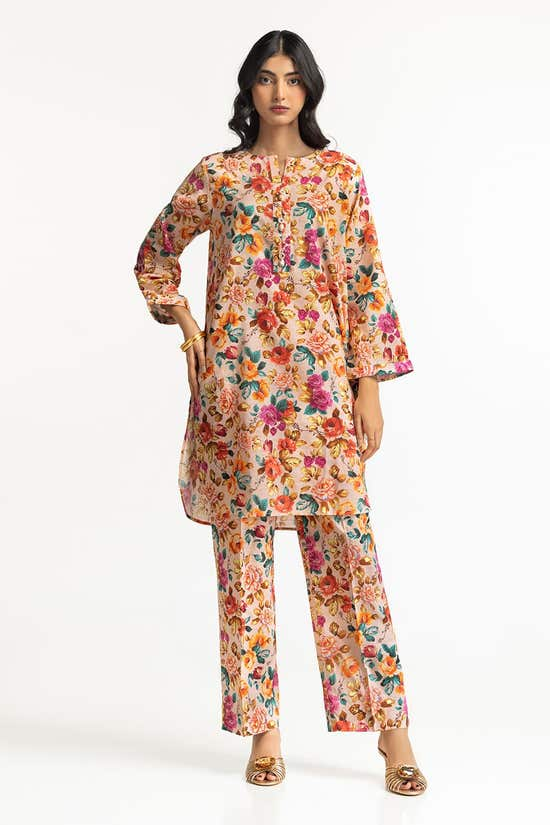

In [20]:
# load image
example = dataset_dict["test"][2]
image = example["image"]
image

In [21]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

ready to wear the suit is a stylive, with a v - neck, a v - neck, a v - neck, a v - neck, a v - neck, a v - neck, and a v - neck, a


Let's check the results on our train dataset!

ValueError: num must be an integer with 1 <= num <= 6, not 7

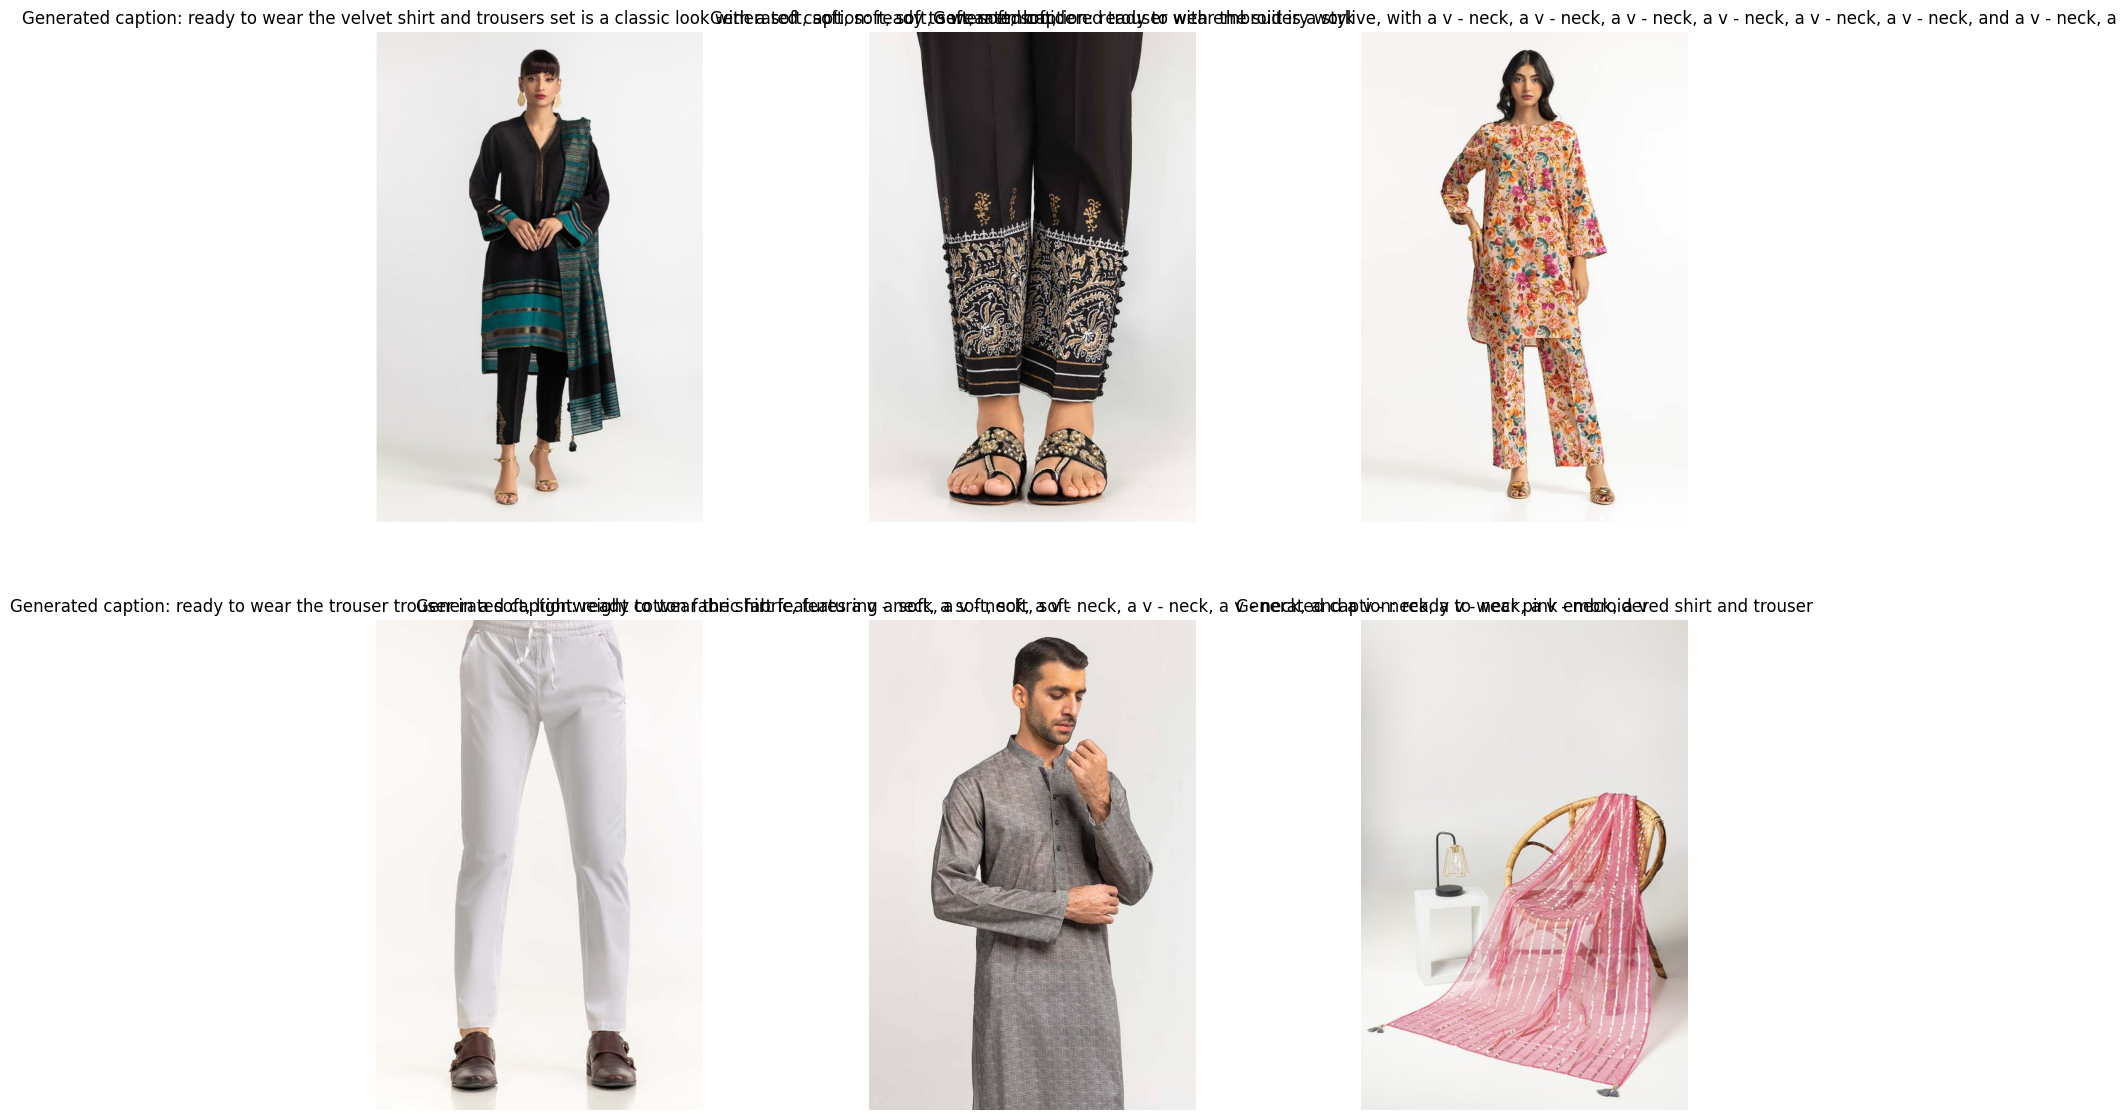

In [32]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset_dict['test']):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")